# Importing Dependencies

In [10]:
import tensorflow as tf, tensorflow.keras.backend as K
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
import re
import math

print("Tensorflow version : " + tf.__version__)

Tensorflow version : 2.4.1


# Setup TPU and Distribution strategy

In [11]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-12-13 17:38:41.908074: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-13 17:38:41.908139: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-12-13 17:38:41.912583: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-13 17:38:41.912654: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


REPLICAS:  8


# Data Import and Preprocessing

In [12]:
from kaggle_datasets import KaggleDatasets
# google cloud store path
PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

print("Google Cloud Store Path : ",PATH)

# paths 
TRAINING_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/train/*.tfrec')
VALID_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/val/*.tfrec')
TEST_IMAGES = tf.io.gfile.glob(f'{PATH}/tfrecords-jpeg-512x512/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']   # 100 - 102


Google Cloud Store Path :  gs://kds-815d280b11fe375202da79512bafaf620b4095ed95aae36da10b22b1


2022-12-13 17:38:48.650824: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-13 17:38:48.694292: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-13 17:38:48.740121: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Setting Variables

In [13]:
# Helper variables
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SHAPE = [512,512]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 15

# Adaptive Learning Rate variables
LR_START = 0.00005
LR_MAX = LR_START 
LR_MIN = 0.00001 
LR_RAMPUP_EPOCHS = 0 
LR_SUSTAIN_EPOCHS = 5 
LR_EXP_DECAY = 0.85

# Data Helper Functions

In [14]:
def decode_image(img):
    '''Load Image From The Dataset'''
    image = tf.io.decode_jpeg(img,channels=3)
    image = tf.cast(image,tf.float32)/255.0
    image = tf.reshape(image,[*IMAGE_SHAPE,3])
    return image

def read_labeled_data(example):
    '''Read Labeled tfrecord'''
    labeled_struct = {
        'image':tf.io.FixedLenFeature([],tf.string),
        'class': tf.io.FixedLenFeature([],tf.int64)
    }
    parsed = tf.io.parse_single_example(example,labeled_struct)
    image = decode_image(parsed['image'])
    label = tf.cast(parsed['class'],tf.int32)
    return image,label

def read_unlabeled_data(example):
    '''Read unlabeled tfrecord'''
    unlabeled_struct = {
        'image':tf.io.FixedLenFeature([],tf.string),
        'id':tf.io.FixedLenFeature([],tf.string)
    }
    parsed = tf.io.parse_single_example(example,unlabeled_struct)
    image = decode_image(parsed['image'])
    idnum = parsed['id']
    return image,idnum

def load_dataset(filenames,is_labeled = True,inorder=False):
    '''Load the tfrecord as Dataset.
    is_labeled(bool) : is the data labeled or unlabeled
    inorder(bool) : Should the data be inorder or loaded as soon as it arrives'''
    options = tf.data.Options()
    if not inorder:
        options.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO)
    dataset = dataset.with_options(options)
    dataset = dataset.map(read_labeled_data if is_labeled else read_unlabeled_data)
    return dataset

def get_training_data():
    '''Load the training dataset'''
    dataset = load_dataset(TRAINING_IMAGES,is_labeled=True)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_valid_data():
    '''Load the validation dataset'''
    dataset = load_dataset(VALID_IMAGES,is_labeled=True,inorder=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_data(ordered=False):
    '''Load the test dataset'''
    dataset = load_dataset(TEST_IMAGES,is_labeled=False,inorder=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_files(filenames):
    '''Count number of files in the dataset'''
    n = [int(re.compile(r"-([0-9]*)\.").search(file).group(1)) for file in filenames]
    return np.sum(n)

def batch_to_numpy(data):
    '''Converts batch of data to numpy '''
    image , label = data
    image = image.numpy()
    label = label.numpy()
    if label.dtype == object:
        label = [None for _ in enumerate(label)]
    return image , label

def display_batch_images(databatch):
    # load data as numpy 
    img,label = batch_to_numpy(databatch)
    
    rows = int(math.sqrt(len(img)))
    cols = len(img)//rows
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
        
    for i , (image, label) in enumerate(zip(img[:rows*cols],label[:rows*cols])):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        plt.imshow(image)
        if label:
            plt.title(CLASSES[label])
        plt.tight_layout()
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
def plot_hist(history,EPOCHS):
    plt.subplot(2,1,1)
    loss = history.history['loss']
    vloss = history.history['val_loss']
    plt.plot(range(1,EPOCHS+1),loss,c='b',label='loss')
    plt.plot(range(1,EPOCHS+1),vloss,c='r',label='val_loss')
    plt.legend()
    plt.subplot(2,1,2)
    acc = history.history['sparse_categorical_accuracy']
    vacc = history.history['val_sparse_categorical_accuracy']
    plt.plot(range(1,EPOCHS+1),acc,c='b',label='accuracy')
    plt.plot(range(1,EPOCHS+1),vacc,c='r',label='val_accuracy')
    plt.legend()
    plt.plot()

# Preparing the Data

Number of training images : 12753 
Number of validation images : 3712 
Number of test images : 7382


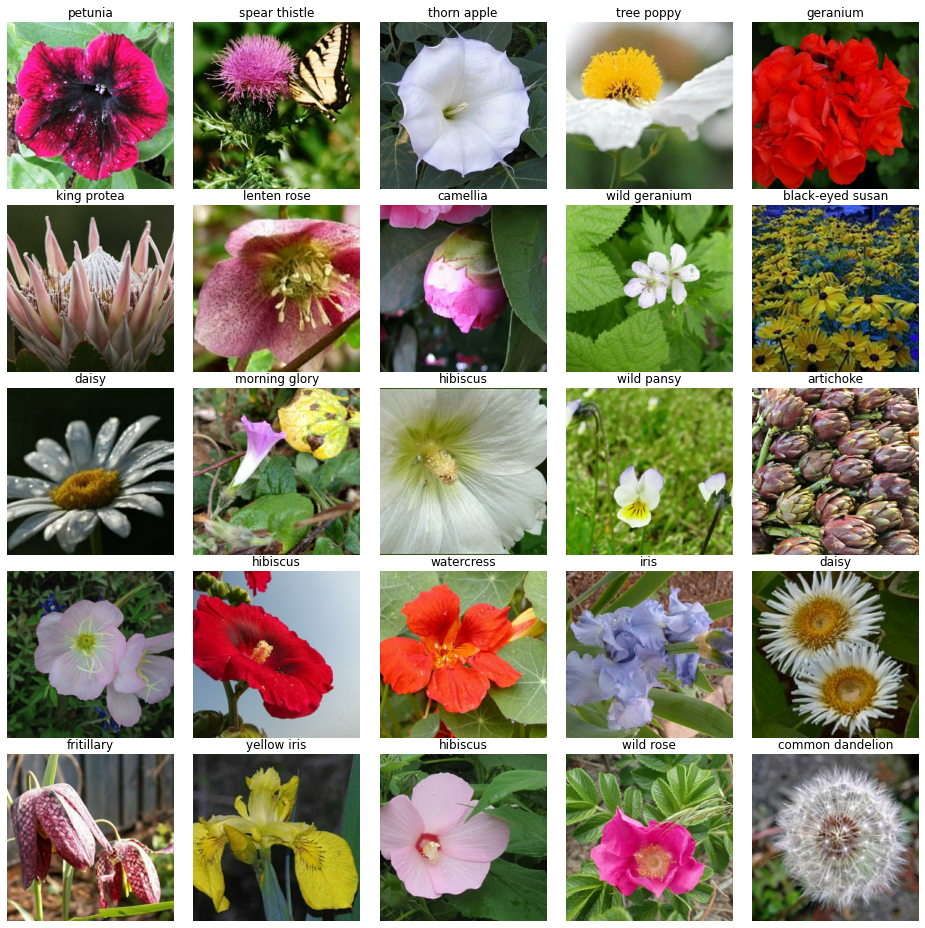

In [15]:
NUM_TRAIN_IMG = count_files(TRAINING_IMAGES)
NUM_VALID_IMG = count_files(VALID_IMAGES)
NUM_TEST_IMG = count_files(TEST_IMAGES)
print(f'Number of training images : {NUM_TRAIN_IMG} \nNumber of validation images : {NUM_VALID_IMG} \nNumber of test images : {NUM_TEST_IMG}')

# get the data
ds_train = get_training_data()
ds_valid = get_valid_data()
ds_test = get_test_data(ordered=True)

display_batch_images(next(iter(ds_valid.unbatch().batch(25))))

# Model Creation and Fine-Tuning

In [16]:
with strategy.scope():
    pt = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE,3)
)
    pt.trainable = True
    model = tf.keras.Sequential([
        pt,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(len(CLASSES),activation='softmax')
    ])
    
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_3 (Dense)              (None, 104)               26728     
Total params: 21,412,752
Trainable params: 21,358,224
Non-trainable params: 54,528
_________________________________________________________________


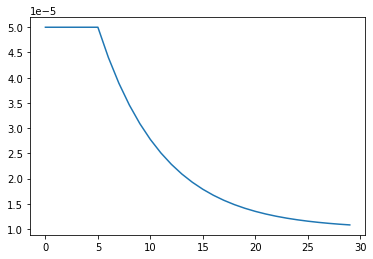

In [17]:
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:  
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)   
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):  
        lr = LR_MAX
    else:    
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)

    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
lr = [lrfn(n) for n in range(30)]
plt.plot(lr)

# Training

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-05.
99/99 [==============================] - 127s 830ms/step - loss: 4.1551 - sparse_categorical_accuracy: 0.1741 - val_loss: 2.6889 - val_sparse_categorical_accuracy: 0.4186


2022-12-13 17:41:09.378837: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 72636, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670953269.378722972","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 72636, Output num: 0","grpc_status":3}


Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 5e-05.
99/99 [==============================] - 59s 596ms/step - loss: 2.3966 - sparse_categorical_accuracy: 0.4932 - val_loss: 1.3756 - val_sparse_categorical_accuracy: 0.6918
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 5e-05.
99/99 [==============================] - 60s 611ms/step - loss: 1.3191 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.7853 - val_sparse_categorical_accuracy: 0.8138
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 5e-05.
99/99 [==============================] - 60s 605ms/step - loss: 0.7684 - sparse_categorical_accuracy: 0.8468 - val_loss: 0.5660 - val_sparse_categorical_accuracy: 0.8680
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 5e-05.
99/99 [==============================] - 60s 610ms/step - loss: 0.4769 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.4563 - val_sparse_categorical_accuracy: 0.8992


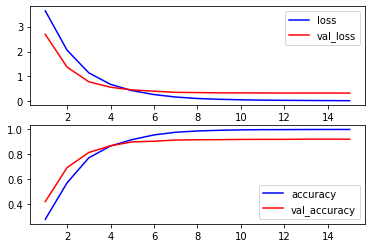

In [18]:
STEPS_PER_EPOCH = NUM_TRAIN_IMG // BATCH_SIZE
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, early_stopping],
)

plot_hist(history,EPOCHS)


# Prediction and Submission

In [19]:
test_images_ds = ds_test.map(lambda image, idnum: image)
test_id_ds = ds_test.map(lambda image, idnum: idnum)

pred = model.predict(test_images_ds)

label_pred = np.argmax(pred,axis=-1)

ids = next(iter(test_id_ds.unbatch().batch(NUM_TEST_IMG))).numpy().astype('U')

df = {
    'id':ids,
    'label':label_pred
}
df = pd.DataFrame(df)

df.to_csv('submission.csv',index=False)

df.head()

2022-12-13 17:56:12.310633: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 109833, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670954172.310549354","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 109833, Output num: 0","grpc_status":3}


,id,label
0,252d840db,67
1,1c4736dea,28
2,c37a6f3e9,83
3,00e4f514e,103
4,59d1b6146,46
